In [1]:
import cvxpy as cp
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

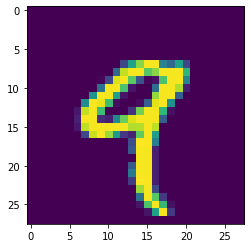

In [3]:
import gzip
f = gzip.open('train-images-idx3-ubyte.gz','r')

image_size = 28
num_images = 100

f.read(16)
buf = f.read(image_size * image_size * num_images)
data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
data = data.reshape(num_images, image_size, image_size, 1)
image = np.asarray(data[4]).squeeze()
plt.imshow(image)

In [6]:
# 3 and 8 are both 1s
p1 = np.asarray(data[0]).squeeze()
p0 = np.asarray(data[4]).squeeze()
assert np.sum(p1) >= np.sum(p0)
norm_factor = max(np.sum(p1), np.sum(p0))
p1 = p1 / norm_factor
p0 = p0 / norm_factor
print(np.sum(p1), np.sum(p0))

1.0 0.8433788


In [50]:
def get_feasible(n, dx, gamma, p0, p1):
    mx = cp.Variable((n-1,n))
    my = cp.Variable((n,n-1))
    p0t = cp.Variable((n,n))
    p1t = cp.Variable((n,n))
    col0 = np.zeros((n,1))
    row0 = np.zeros((1,n))

    objective = cp.Minimize(1)

    # Assumes that p1t has larger mass
    constraints = [
        dx*(p0t - p1t) == cp.vstack([mx,row0])-cp.vstack([row0,mx])+cp.hstack([my,col0])-cp.hstack([col0,my]),
        p0t >= 0,
        p0t <= p0,
        p1t >= 0,
        p1t <= p1,
        cp.sum(p0t) == gamma,
        cp.sum(p1t) == gamma,
    ]
    prob = cp.Problem(objective, constraints)
    prob_val = prob.solve()
    return mx, my, p0t, p1t

In [55]:
a, b, c, d = get_feasible(28, 1/(n-1), 0.7, p0, p1)

In [52]:
cp.sum(cp.norm(cp.vstack([cp.vec(cp.hstack([b, col0])), cp.vec(cp.vstack([a, row0]))]),axis=0)).value

1.3557118344473928

In [36]:
cp.sum(cp.abs(dx*(p0t - p1t) -( cp.vstack([mx,row0])-cp.vstack([row0,mx])+cp.hstack([my,col0])-cp.hstack([col0,my])))).value

4.64156617827608e-17

## ScratcH

In [42]:
n = 3
div_matrix = np.zeros((n**2,2*n*(n-1)))
ct = 0
for i in range(n):
    for j in range(n):
        if i != n-1:
            div_matrix[ct,i*n+j] = 1
        if i != 0:
            div_matrix[ct,(i-1)*n+j] = -1
        if j != n-1:
            div_matrix[ct,n*(n-1)+i*(n-1)+j] = 1
        if j != 0:
            div_matrix[ct,n*(n-1)+i*(n-1)+j-1] = -1
        ct += 1  
b = np.random.normal(size=(n**2,1))
x = np.linalg.lstsq(div_matrix, b, rcond=None)[0]
print(div_matrix@x-b)

[[-0.07642363]
 [-0.07642363]
 [-0.07642363]
 [-0.07642363]
 [-0.07642363]
 [-0.07642363]
 [-0.07642363]
 [-0.07642363]
 [-0.07642363]]
